Importing necessary libraries and modules (each module will be explained as you go through the code)

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn

Define the device to use (in case you do not know whether GPU is there or not)

**cuda** is basically a parallel computing platform and programming model created by **NVIDIA**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define the transform to preprocess the data, **transforms** are imported from **torchvision** library (above) and are used to usually scale, normalize and convert input to tensor datatype

In [3]:
# We normalize each channel of the image by subtracting the mean by 0.5 and dividing standard deviation by 2
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   

The above **transform** will be used while loading training and test datasets

In [4]:
"""
Loading the train and test datasets in root directory "data", downloading is set to true.
For "trainset", train is set to True because ofcourse it is a training set and set False for testset.
"""
trainset = datasets.CIFAR10(root="~/data",
                            download=True,
                            train=True,
                            transform=transform)

testset = datasets.CIFAR10(root="~/data",
                           download=True,
                           train=False,
                           transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 79313958.17it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified


Dataloaders are used to input the data into the model in batches which helps the model to consume large datasets efficiently. Moreover, it shuffles the data if "shuffle=True"!

In [5]:
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)

Now, we will define the pretrained ResNet50 model using module "models" from "torchvision" library and tune the last layer of the model.

In [6]:
resnet = models.resnet50(pretrained=50)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Freeze all the layers but last layer and replace the last fully-connected new layer with a new layer.

In [7]:
# Freezing all layers in the model
for param in resnet.parameters():
  param.requires_grad = False

# Replacing last layer with a new one
num_features =  resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)

Move the model to device.

In [8]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Initialize **criterion** as cross entropic loss and select **optimizer** as Stochastic gradient descent with **learning rate** = 0.01 and **momentum** = 0.9.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=resnet.fc.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Train the model
EPOCH = 25
print("=========================================== START TRAINING ===========================================")
for epoch in range(EPOCH):
  running_loss = 0.0
  correct, total = 0, 0
  for i, data in enumerate(trainloader, 0):
    # Load images and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # Reset the gradient to zero
    optimizer.zero_grad()

    # Forward pass
    outputs = resnet(inputs)
    # Calculate loss
    loss = criterion(outputs, labels)
    # Backward pass
    loss.backward()
    # Update the weights
    optimizer.step()

    # Calculate loss for each iteration
    running_loss += loss.item()
    # Get the predictions
    _, predicted = torch.max(outputs.data, 1)
    # Update total and correct predictions
    total += labels.size(0)
    correct += (predicted==labels).sum().item()

    # Print loss and training accuracy for every 100th iteration for each epoch 
    if i%100 == 99:
      print(f"epoch: {epoch+1}, running_loss: {running_loss/100}, Training Accuracy: {correct/total*100}")
      running_loss = 0.0
print("=========================================== FINISHED TRAINING ===========================================")

=========================================== START TRAINING ===========================================
epoch: 1, running_loss: 0.9921307802200318, Training Accuracy: 67.109375
epoch: 1, running_loss: 0.6661632713675499, Training Accuracy: 72.30859375
epoch: 1, running_loss: 0.6410796400904656, Training Accuracy: 74.10677083333333
epoch: 2, running_loss: 0.5839819890260697, Training Accuracy: 79.7890625
epoch: 2, running_loss: 0.5709073773026466, Training Accuracy: 79.91015625
epoch: 2, running_loss: 0.5665945819020272, Training Accuracy: 80.15625
epoch: 3, running_loss: 0.5627507790923119, Training Accuracy: 80.6328125
epoch: 3, running_loss: 0.545679162144661, Training Accuracy: 80.7265625
epoch: 3, running_loss: 0.5450544279813766, Training Accuracy: 80.76041666666667
epoch: 4, running_loss: 0.5287867933511734, Training Accuracy: 81.6328125
epoch: 4, running_loss: 0.5279919272661209, Training Accuracy: 81.71484375
epoch: 4, running_loss: 0.5245996999740601, Training Accuracy: 81.7473

Save the model

In [11]:
PATH = "RESNET_CLASSIFIER2.pth"
torch.save(resnet, PATH)

Evaluation of model

accuracy_calculation() takes testloader, model and boolean condition whether accuracy is to be calculated for perturbed dataset or clean dataset (default=False)

In [12]:
def accuracy_calculation(testloader, model, attack=False):
  correct, total = 0, 0
  for data in testloader:
    # Extract input images and respective labels
    inputs, labels = data
    # Move the images and their labels to device (for GPU processing)
    inputs, labels = inputs.to(device), labels.to(device)
    # This condition checks whether the input images are adversarial or not
    if attack:
      adversarial_inputs, noise_grad = fast_gradient_sign_method(resnet, inputs, labels, epsilon)
      # The model consumes adversarial inputs which are obtained from fast_gradient_sign_method()
      outputs = resnet(adversarial_inputs)
    else:
      # The model consumes clean test images
      outputs = resnet(inputs)
    # Get the predictions 
    _, predicted = torch.max(outputs.data, 1)

    # Update total and correct predictions and return them
    total += labels.size(0)
    correct += (predicted==labels).sum().item()
  return correct, total

Calculate test accuracy on clean test images

In [13]:
correct, total = accuracy_calculation(testloader, resnet, attack=False)

# Print accuracy calculated from totat and correct predictions
print(f"Accuracy on original test images: {correct/total*100}")

Accuracy on original test images: 82.13000000000001


Install cleverhans library for attacking the testset

In [14]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.1 MB/s eta 0:00:00


Import numpy and "fast_gradient_method" from cleverhans library

In [15]:
import numpy as np
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

Define a function with input as clean test images and epsilon (perturbation severity)

In [16]:
def fast_gradient_sign_method(model, imgs, labels, epsilon):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

Evaluate model accuracy on perturbed test images

In [17]:
import torch.nn.functional as F

In [18]:
# List of epsilon values ranging from 0.1 to 0.55
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
accuracies = []
for epsilon in epsilons:
  correct, total = accuracy_calculation(testloader, resnet, attack=True)
  accuracies.append(correct/total*100)
  print(f"Epsilon: {epsilon} with accuracy on perturbed test images: {correct/total*100}")

Epsilon: 0.1 with accuracy on perturbed test images: 51.949999999999996
Epsilon: 0.15 with accuracy on perturbed test images: 49.9
Epsilon: 0.2 with accuracy on perturbed test images: 46.78
Epsilon: 0.25 with accuracy on perturbed test images: 44.379999999999995
Epsilon: 0.3 with accuracy on perturbed test images: 42.35
Epsilon: 0.35 with accuracy on perturbed test images: 40.27
Epsilon: 0.4 with accuracy on perturbed test images: 39.18
Epsilon: 0.45 with accuracy on perturbed test images: 36.85
Epsilon: 0.5 with accuracy on perturbed test images: 37.019999999999996
Epsilon: 0.55 with accuracy on perturbed test images: 35.24


Importing matplotlib.pyplot library to display plots and images

In [19]:
import matplotlib.pyplot as plt

We will plot the relationship between **epsilon** and **test accuracies**.

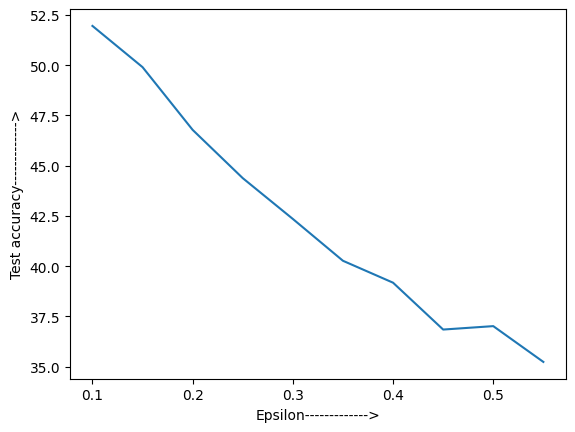

In [23]:
plt.plot(epsilons, accuracies)
plt.xlabel("Epsilon------------->")
plt.ylabel("Test accuracy------------->")
plt.show()

**display_images()** predicts and displays clean prediction with respect to true class, also perturbed prediction with respect to true class for the same test images and displays number of images entered by the user.

In [24]:
def display_images(number_images, testloader):
  fig, ax = plt.subplots(nrows=number_images, ncols=2, figsize=(10, 25))

  for i, data in enumerate(testloader):
    if i == number_images:
      break
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    true_label = testset.classes[labels[0]]
    adv_images, noise_grad = fast_gradient_sign_method(resnet, images, labels, epsilon)
    outputs = resnet(images)
    _, predicted = torch.max(outputs.data, 1)
    original_class = predicted[0].item()
    lab = testset.classes
    adv_images = adv_images.to(device)
    outputs = resnet(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    perturbed_class = predicted[0].item()
    ax[i, 0].imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)))
    ax[i, 0].set_title(f"Original image with class: {lab[original_class]}\n True class: {true_label}")
    ax[i, 1].imshow(np.transpose(adv_images[0].cpu().detach().numpy(), (1, 2, 0)))
    ax[i, 1].set_title(f"Perturbed image with class: {lab[perturbed_class]}\n True class: {true_label}")

  plt.tight_layout()
  plt.show()

Displaying 5 images for clean and perturbed test images each with resulting predictions and true class labels as well!

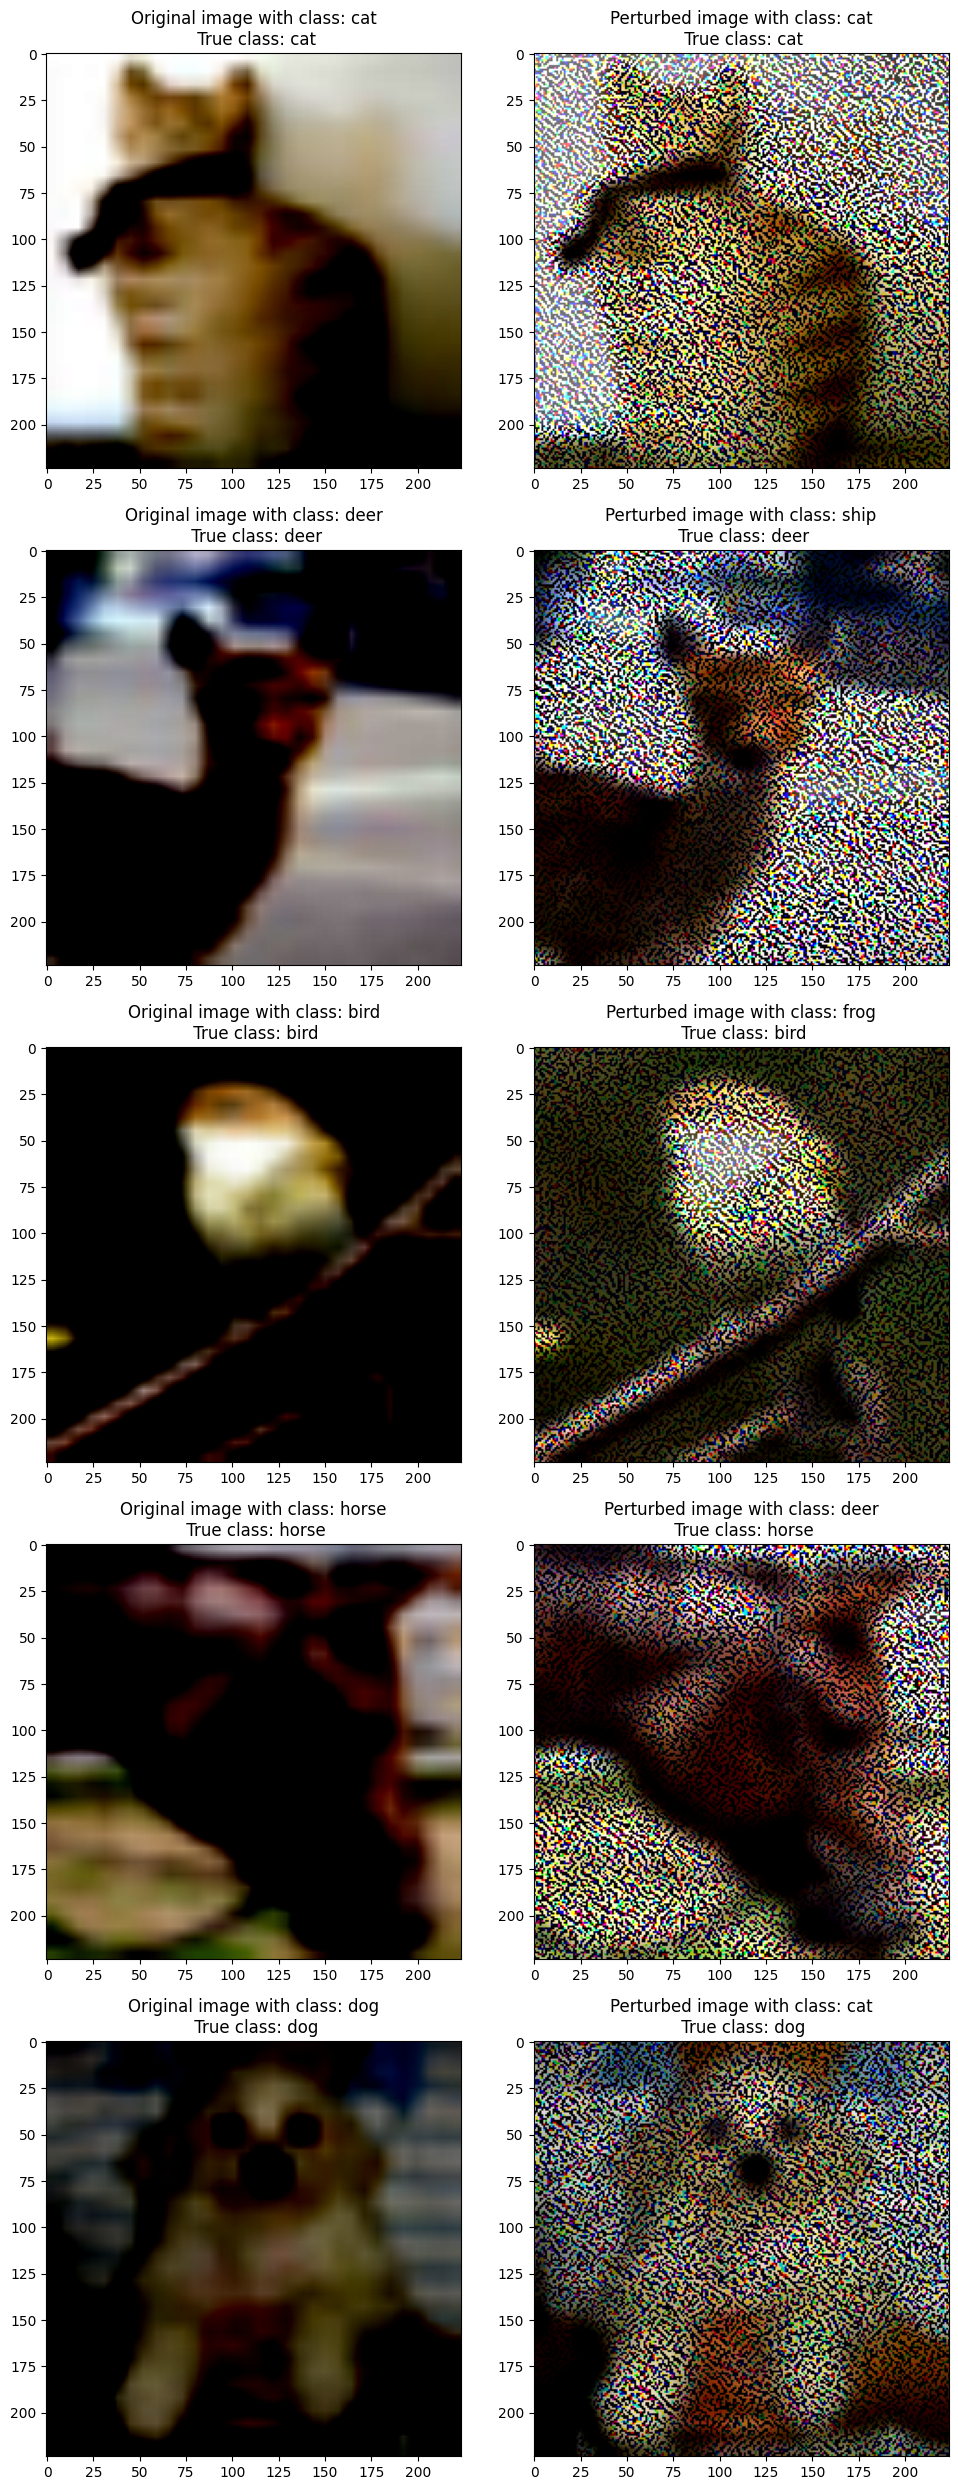

In [26]:
display_images(number_images=5, testloader=testloader)